In [1]:
import random
import csv
import os
import pickle

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from matplotlib import pyplot as plt
import sys

from matplotlib.ticker import FormatStrFormatter
from scipy.signal import find_peaks

from tqdm import tqdm

from utils.eval.eval_utils import evaluate_peaks, compute_ROC
from utils.misc.misc import shuffle_lists_by_group
from utils.training.metrics import accuracy_for_segmenter, AUC_for_segmenter
from utils.training.data_loading import get_line_to_dataset_waveform
from utils.training.keras_models import get_phasenet_model

2023-12-06 16:16:09.086295: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 16:16:09.144152: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 16:16:09.144188: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 16:16:09.144207: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 16:16:09.152845: I tensorflow/core/platform/cpu_feature_g

In [2]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/waveforms"
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/HYDROMOMAR_2013/waveforms"
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/OHASISBIO_2020/waveforms"
BATCH_SIZE = 64
CHECKPOINT = "/media/plerolland/LaBoite/PublicData/trainings/checkpoints_auc_acc/checkpoints_seg_waveforms/all/cp-0019.ckpt"

SIZE = int(2**(np.ceil(np.log2(100*240+1))))  # number of points in each file rounded to the next pow of 2
CHANNELS = 1  # 1 means grayscale 3 RGB
DURATION_S = 100  # duration of the spectrograms in s
OBJECTIVE_CURVE_WIDTH = 10  # defines dispersion of objective function in s

ALLOWED_ERROR_S = 10  # tolerance when evaluating and time distance allowed between two peaks in the probabilities distribution
MIN_PROBA = 0.0001  # minimum value of the output of the segmenter model to record it
TIME_RES = DURATION_S / SIZE
OUTPUT_FILES_SUFFIX = "phasenet_oha2020"

data_loader = get_line_to_dataset_waveform(size=SIZE, duration_s=DURATION_S, objective_curve_width=OBJECTIVE_CURVE_WIDTH)
model = get_phasenet_model(SIZE)
m = model()
m.load_weights(CHECKPOINT)
m.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(),
            loss=tf.losses.binary_crossentropy,
            metrics=[accuracy_for_segmenter, AUC_for_segmenter()])

2023-12-06 16:16:12.041407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 16:16:12.096838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 16:16:12.097013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# open the csv listing data, shuffling the lines
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)[:1000]
print(len(lines), "files found")
x, y = data_loader(lines)
dataset = tf.data.Dataset.from_tensor_slices((list(x), list(y)))
dataset = dataset.batch(batch_size=BATCH_SIZE)

1000 files found


 53%|█████▎    | 528/1000 [00:01<00:01, 293.95it/s]

KeyboardInterrupt



In [12]:
history = m.evaluate(dataset)

2023-12-05 15:34:24.492081: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-05 15:34:25.217608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-05 15:34:25.908076: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


16/16 [==============================] - 7s 158ms/step - loss: 0.0879 - accuracy_for_segmenter: 0.8330 - auc_for_segmenter: 0.8827


In [13]:
detected_peaks = []
ground_truth_peaks = []
for x, y in tqdm(dataset, total=1+int(len(lines)/BATCH_SIZE)):
    predicted = m.predict(x, verbose=False)
    for i, p in enumerate(predicted):
        detected_peaks.append(find_peaks(p, height=MIN_PROBA, distance=ALLOWED_ERROR_S/TIME_RES))
        _y = y[i,:,0] if len(y.shape) == 3 else y[i, :]
        ground_truth_peaks.append(find_peaks(_y, height=MIN_PROBA, distance=ALLOWED_ERROR_S/TIME_RES))
        
detected_peaks = [[(d[0][i]*TIME_RES, d[1]["peak_heights"][i]) for i in range(len(d[0]))] for d in detected_peaks]
ground_truth_peaks = [d[0]*TIME_RES for d in ground_truth_peaks]

100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


In [14]:
i,j = 0,0
for idx in range(len(detected_peaks)):
    i+=len(detected_peaks[idx])
    j+=len(ground_truth_peaks[idx])
print(f"{i} peaks found out of {j}")

7542 peaks found out of 249


In [15]:
TP, FP, TP_per_seg, TN_per_seg, FP_per_seg, FN_per_seg, P_per_seg, N_per_seg = evaluate_peaks(ground_truth_peaks, detected_peaks, ALLOWED_ERROR_S)

In [16]:
print(len(TP), FP)
print(len(TP_per_seg), TN_per_seg, len(FP_per_seg), FN_per_seg, P_per_seg, N_per_seg)

248 7294
233 0 767 0 233 767


In [1]:
TPr, FPr = compute_ROC(TP_per_seg, P_per_seg, FP_per_seg, N_per_seg, thresh_delta=0.001)
plt.plot(FPr, TPr)
np.save(f"data/FPr_{OUTPUT_FILES_SUFFIX}.npy", FPr)
np.save(f"data/TPr_{OUTPUT_FILES_SUFFIX}.npy", TPr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.title("ROC curve")
plt.savefig(f"data/ROC_{OUTPUT_FILES_SUFFIX}.png")

NameError: name 'compute_ROC' is not defined

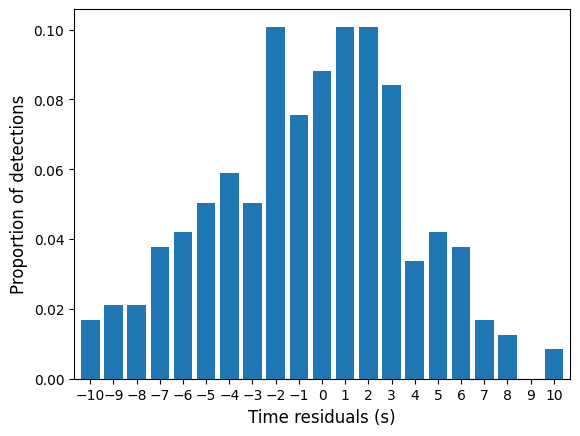

In [10]:
BAR_WIDTH = 0.9
step = 40*TIME_RES

extremum = step * np.round(ALLOWED_ERROR_S / step)
allowed_d = np.arange(-extremum, extremum+step, step)
TP_by_distance = {i : 0 for i in allowed_d}
for p in TP:
    thresh_s = allowed_d[np.argmin(np.abs(p[1] - allowed_d))]
    TP_by_distance[thresh_s] += 1
TP_by_distance = np.array(list(TP_by_distance.values())) / len(TP)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plt.bar(allowed_d, TP_by_distance, width=BAR_WIDTH, align='center')
plt.xticks(allowed_d)
plt.xlim(allowed_d[0]-0.5-(1-BAR_WIDTH), allowed_d[-1]+0.5+(1-BAR_WIDTH))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.xlabel('Time residuals (s)', fontsize=12)
plt.ylabel('Proportion of detections', fontsize=12)
plt.savefig(f'data/histogram_{OUTPUT_FILES_SUFFIX}.png', bbox_inches='tight')